# Diversified Stock Portfolio using clustering

*Project done by* **Iqbi Hamza**

### Importing necessary libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {"grid.color": "white"})
from datetime import date

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

import shap

import warnings
# Filter FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, 
                        module="sklearn")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### Exploratory Data Analysis

In [2]:
# Get the historical data for Microsoft as an example
msft = yf.Ticker("MSFT") 
stock_data_msft_example = msft.history(period="1mo")

# show meta information about the history (requires history() to be called first)
msft.history_metadata
# get all stock info : msft.info

{'currency': 'USD',
 'symbol': 'MSFT',
 'exchangeName': 'NMS',
 'instrumentType': 'EQUITY',
 'firstTradeDate': 511108200,
 'regularMarketTime': 1689969601,
 'gmtoffset': -14400,
 'timezone': 'EDT',
 'exchangeTimezoneName': 'America/New_York',
 'regularMarketPrice': 343.77,
 'chartPreviousClose': 333.56,
 'priceHint': 2,
 'currentTradingPeriod': {'pre': {'timezone': 'EDT',
   'start': 1689926400,
   'end': 1689946200,
   'gmtoffset': -14400},
  'regular': {'timezone': 'EDT',
   'start': 1689946200,
   'end': 1689969600,
   'gmtoffset': -14400},
  'post': {'timezone': 'EDT',
   'start': 1689969600,
   'end': 1689984000,
   'gmtoffset': -14400}},
 'dataGranularity': '1d',
 'range': '1mo',
 'validRanges': ['1d',
  '5d',
  '1mo',
  '3mo',
  '6mo',
  '1y',
  '2y',
  '5y',
  '10y',
  'ytd',
  'max']}

In [3]:
stocks = ["AAPL", "MSFT", "AEE", "AIG", "ADBE", "NVDA", "META",
          "ROST", "JD", "PDD", "DDOG", "GOOGL", "AMZN", "SPY", "NDAQ"]

# Get the data for the stocks
today = date.today()
stock_data = yf.download(stocks, start="2022-07-10", end=today)

[*********************100%***********************]  15 of 15 completed


In [4]:
stock_data.columns

MultiIndex([('Adj Close',  'AAPL'),
            ('Adj Close',  'ADBE'),
            ('Adj Close',   'AEE'),
            ('Adj Close',   'AIG'),
            ('Adj Close',  'AMZN'),
            ('Adj Close',  'DDOG'),
            ('Adj Close', 'GOOGL'),
            ('Adj Close',    'JD'),
            ('Adj Close',  'META'),
            ('Adj Close',  'MSFT'),
            ('Adj Close',  'NDAQ'),
            ('Adj Close',  'NVDA'),
            ('Adj Close',   'PDD'),
            ('Adj Close',  'ROST'),
            ('Adj Close',   'SPY'),
            (    'Close',  'AAPL'),
            (    'Close',  'ADBE'),
            (    'Close',   'AEE'),
            (    'Close',   'AIG'),
            (    'Close',  'AMZN'),
            (    'Close',  'DDOG'),
            (    'Close', 'GOOGL'),
            (    'Close',    'JD'),
            (    'Close',  'META'),
            (    'Close',  'MSFT'),
            (    'Close',  'NDAQ'),
            (    'Close',  'NVDA'),
            (    'Close',   

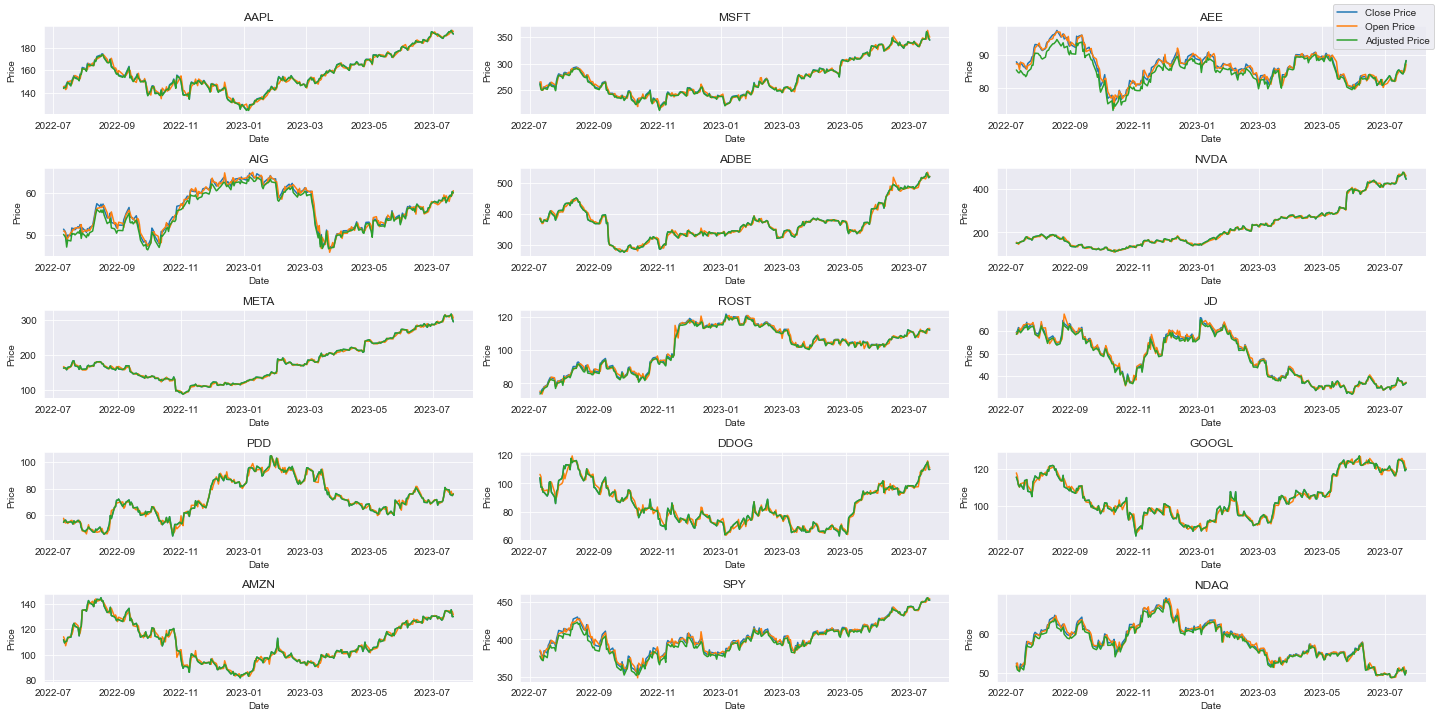

In [5]:
f = plt.figure(figsize=(20, 10))
for i, stock in enumerate(stocks) :
    plt.subplot(5, 3, i + 1)
    plt.plot(stock_data["Close"][stock], label='Close Price')
    plt.plot(stock_data["Open"][stock], label='Open Price')
    plt.plot(stock_data["Adj Close"][stock], label = "Adjusted Price")
    plt.title(stock)
    plt.xlabel('Date')
    plt.ylabel('Price')
    if i==0 : f.legend()

plt.tight_layout()
plt.show()

We can see that almost all stocks have the same upwards tendency in all of 3 the prices. The only exception is the NASDAQ index. However, the variations are heavy and abrupt.

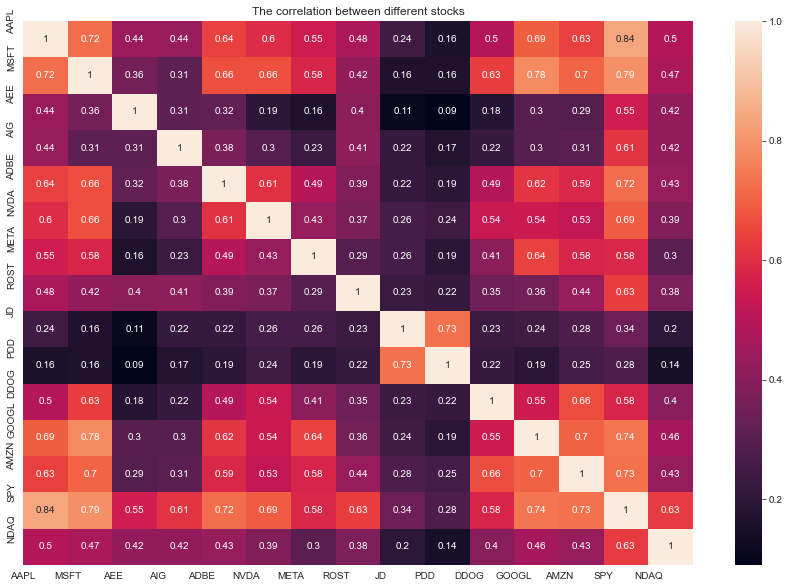

In [6]:
plt.figure(figsize=(15, 10))
sns.heatmap(pd.concat([stock_data['Adj Close'][stock].pct_change() for stock in stocks], axis=1).corr(), annot=True)
plt.yticks(range(len(stocks)), stocks)
plt.xticks(range(len(stocks)), stocks)
plt.title("The correlation between different stocks")
plt.show()

The observed results and correlations between stocks seem coherent, and we can assume that there are no anomalies in the data we have.

### Clustering to construct a diversified Portfolio

In [7]:
all_stocks = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'GOOG', 'INTC', 'NVDA', 'ADBE',
               'PYPL', 'CSCO', 'NFLX', 'PEP', 'TSLA', 'CMCSA', 'AMGN', 'COST', 'TMUS', 'AVGO',
               'TXN', 'CHTR', 'QCOM', 'GILD', 'SBUX', 'INTU', 'VRTX', 'MDLZ', 'ISRG',
               'BKNG', 'ADP', 'REGN', 'ATVI', 'AMD', 'JD', 'MU', 'AMAT', 'ILMN', 'ADSK',
               'CSX', 'MELI', 'LRCX', 'ADI', 'ZM', 'BIIB', 'EA', 'KHC', 'WBA', 'LULU',
               'EBAY', 'MNST', 'DXCM', 'EXC', 'BIDU', 'XEL', 'WDAY', 'DOCU', 'SPLK', 'ORLY',
               'NXPI', 'CTSH', 'KLAC', 'SNPS', 'SGEN', 'ASML', 'IDXX', 'CSGP', 'CTAS', 'VRSK',
               'MAR', 'CDNS', 'PAYX', 'MCHP', 'SIRI', 'ANSS', 'VRSN', 'FAST', 'BMRN',
               'INCY','DLTR', 'SWKS', 'ALGN', 'CPRT', 'TTWO', 'CDW',
               'CHKP', 'WDC', 'ULTA', 'NTAP', 'FOXA', 'LBTYK']

all_stock_data = yf.download(all_stocks, start="2013-07-10", end=today)

[*********************100%***********************]  89 of 89 completed


We have to select some features in order to cluster the stocks that we dispose of :

- **Annualized Return on Equity** : is a financial metric to measure the profitability and efficiency of a company's equity investments over a specific period (typically a year). It provides insights into how effectively a company generates profits from the capital invested by its shareholders.

- **Annualized Volatility on Equity** : measures the level of fluctuation or variability in the returns generated by a company's equity investments over a specific period. It quantifies the degree of uncertainty or risk associated with the performance of a company's equity.

-  **Sharpe Ratio** : is the average return earned in excess of the risk-free rate per unit of volatility or total risk. It helps investors evaluate the efficiency and attractiveness of an investment opportunity by considering both risk and return.

- **Correlation with S&P 500 index** : quantifies the extent to which the asset's price movements move in the same direction and magnitude as the movements of the index.

- **Beta with S&P 500 index** : measures the systematic risk or volatility of an individual asset or investment relative to the index (as a chosen benchmark). It quantifies the asset's sensitivity to market movements.

These last two features are used for the backtesting against the S&P 500 index to actually make sense.

In [8]:
start_date = "2013-01-01"
end_date = "2019-12-31"

index_ticker = "SPY"
index = yf.Ticker(index_ticker)
index_history = index.history(start=start_date, end=end_date)
index_adj_close = index_history["Close"]

#Create a dataset to fill 
data = pd.DataFrame(columns=["Stock", "Annualized Return on Equity",
                                "Annualized Volatility on Equity", 
                                "Sharpe Ratio", "Correlation", "Beta"])

for stock_ticker in all_stocks :
    
    # Extract the adjusted close prices for both
    stock = yf.Ticker(stock_ticker)
    history = stock.history(start=start_date, end=end_date)

    stock_adj_close = history["Close"]
    daily_returns = history["Close"].pct_change()
    
    # Calculate annualized return on equity (daily returns)
    annualized_return_on_equity = daily_returns.mean() * 252
    
    # Calculate annualized volatility on equity (daily returns)
    annualized_volatility_on_equity = daily_returns.std() * np.sqrt(252)
    
    # Calculate Sharpe Ratio
    risk_free_rate = 0.02  # Assuming a risk-free rate of 2%
    sharpe_ratio = (annualized_return_on_equity - risk_free_rate) / annualized_volatility_on_equity
    
    # Calculate the correlation with the S&P 500 index
    correlation = stock_adj_close.corr(index_adj_close)
    
    # Calculate the Beta with the S&P 500 index
    beta = correlation * (stock_adj_close.std() / index_adj_close.std())
    
    # create a line in a dataset with the computed variables
    data.loc[len(data)] = [stock_ticker, annualized_return_on_equity, 
                           annualized_volatility_on_equity,
                           sharpe_ratio, correlation, beta]
    

In [9]:
data.head()

,Stock,Annualized Return on Equity,Annualized Volatility on Equity,Sharpe Ratio,Correlation,Beta
0,AAPL,0.237986,0.249534,0.873572,0.973867,0.271214
1,MSFT,0.299394,0.229559,1.217088,0.967460,0.704414
2,AMZN,0.325344,0.293999,1.038589,0.957936,0.596366
3,GOOGL,0.213975,0.231715,0.837128,0.975067,0.286715
4,GOOG,0.214623,0.233308,0.834188,0.976724,0.287443


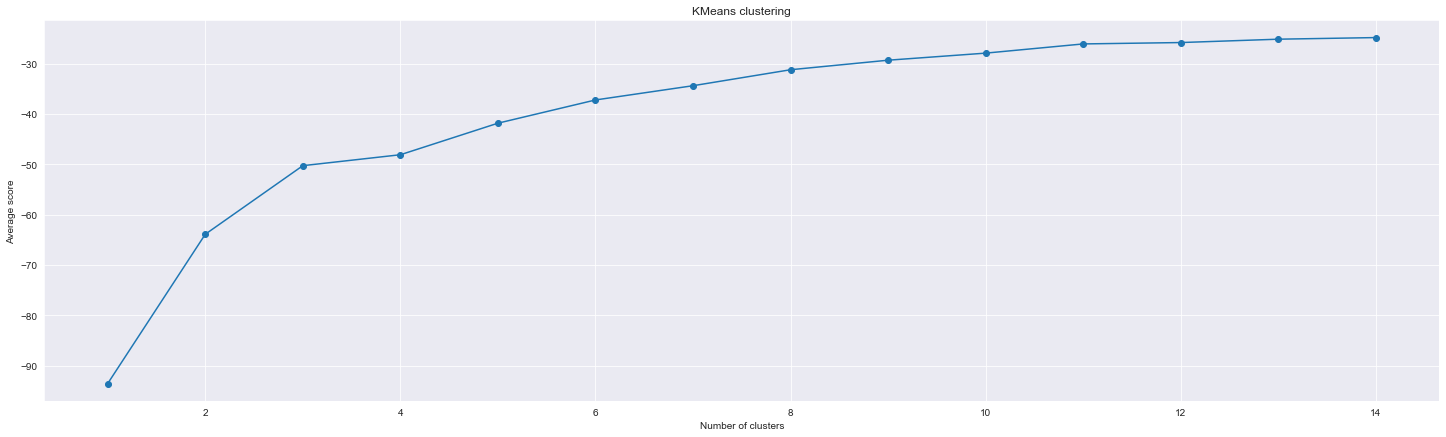

In [10]:
# Create a dataset with the features we want to cluster
X = data[["Annualized Return on Equity", "Annualized Volatility on Equity",
        "Sharpe Ratio", "Correlation", "Beta"]]
X = StandardScaler().fit_transform(X)

K = np.arange(1, 15)
# do a grid search with kmeans
grid = GridSearchCV(KMeans(), param_grid={'n_clusters': K}, cv=5)
grid.fit(X)

# plot
plt.figure(figsize=(25, 7))
plt.plot(K, grid.cv_results_['mean_test_score'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Average score')
plt.title('KMeans clustering')
plt.show()

Text(0.5, 1.0, 'Clusters of stocks')

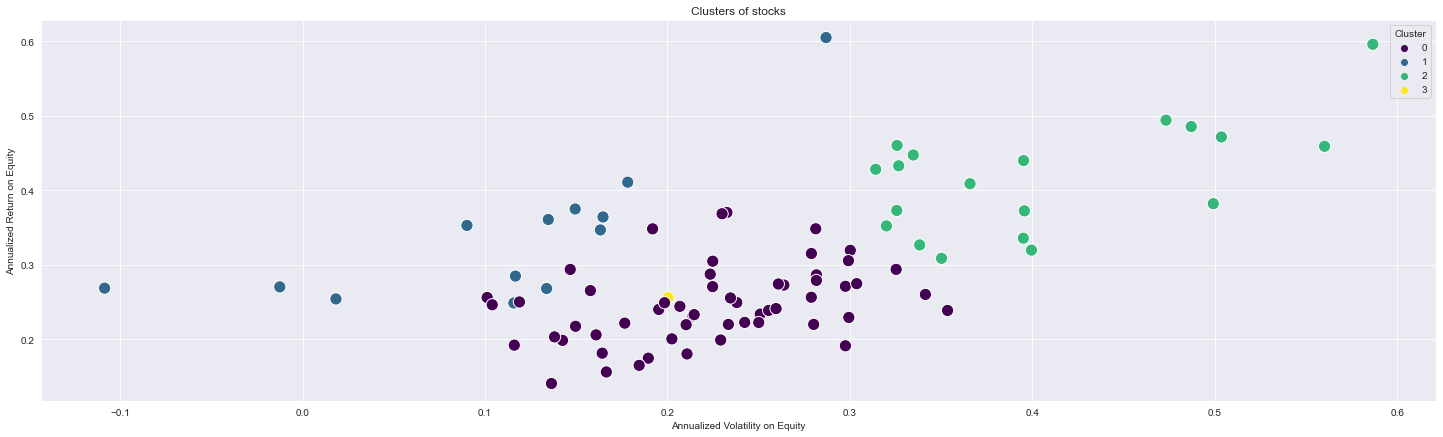

In [11]:
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit_predict(X)

# Add the clusters to our dataset
data["Cluster"] = clusters

# Plot the clusters   
plt.figure(figsize=(25, 7))
sns.scatterplot(data=data, x="Annualized Return on Equity", y="Annualized Volatility on Equity", 
                hue="Cluster", s=150, palette="viridis")
plt.xlabel("Annualized Volatility on Equity")
plt.ylabel("Annualized Return on Equity")
plt.title("Clusters of stocks")

In [12]:
data.head()

,Stock,Annualized Return on Equity,Annualized Volatility on Equity,Sharpe Ratio,Correlation,Beta,Cluster
0,AAPL,0.237986,0.249534,0.873572,0.973867,0.271214,0
1,MSFT,0.299394,0.229559,1.217088,0.967460,0.704414,0
2,AMZN,0.325344,0.293999,1.038589,0.957936,0.596366,0
3,GOOGL,0.213975,0.231715,0.837128,0.975067,0.286715,0
4,GOOG,0.214623,0.233308,0.834188,0.976724,0.287443,0


In [13]:
# Group the clusters
cluster_0 = data[data["Cluster"]==0]
cluster_1 = data[data["Cluster"]==1]
cluster_2 = data[data["Cluster"]==2]
cluster_3 = data[data["Cluster"]==3]

invalid value encountered in reduce
invalid value encountered in reduce
invalid value encountered in reduce
invalid value encountered in reduce
invalid value encountered in reduce
invalid value encountered in reduce


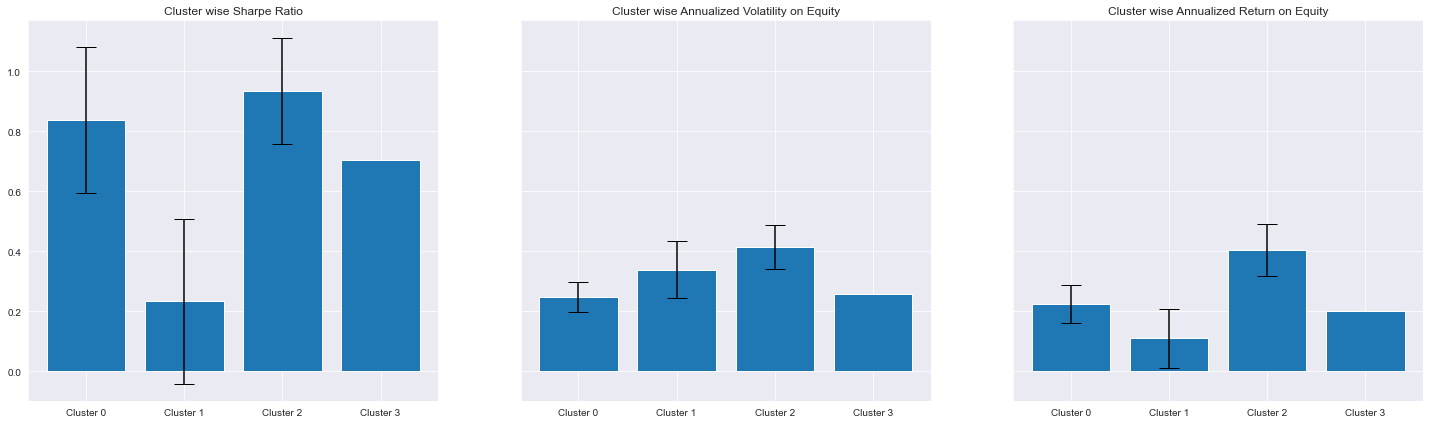

In [14]:
selected_features = ["Sharpe Ratio", "Annualized Volatility on Equity", "Annualized Return on Equity"]
# subplots with different scales

f, axes = plt.subplots(1, 3, figsize=(25, 7), sharey=True)
for ax, feature in zip(axes, selected_features) :
        mean_feature_0 = cluster_0[feature].mean()
        mean_feature_1 = cluster_1[feature].mean()
        mean_feature_2 = cluster_2[feature].mean()
        mean_feature_3 = cluster_3[feature].mean()
        
        std_feature_0 = cluster_0[feature].std()
        std_feature_1 = cluster_1[feature].std()
        std_feature_2 = cluster_2[feature].std()
        std_feature_3 = cluster_3[feature].std()
        
        ax.bar(x=["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"],
                height=[mean_feature_0, mean_feature_1, mean_feature_2, mean_feature_3],
                yerr=[std_feature_0, std_feature_1, std_feature_2, std_feature_3],
                capsize=10)
        ax.set_title("Cluster wise " + feature)

In [15]:
# Portfolio construction
portfolio = []
for cluster in [0, 1, 2, 3] :
    # select the top 3 stocks with sharp ratio and get their name
    top_3_sharp_ratio = data[data["Cluster"]==cluster].sort_values(by="Sharpe Ratio", ascending=False).head(3)["Stock"].values
    for ticker in top_3_sharp_ratio :
        portfolio.append(ticker)
print(f"The stocks selected in the portfolio : {portfolio}")

The stocks selected in the portfolio : ['CTAS', 'CDW', 'ADBE', 'ZM', 'GILD', 'REGN', 'NVDA', 'AVGO', 'NFLX', 'BKNG']


### Backtesting against S&P 500 index 

To do so, we'll use historical data, different from the one used in clustering. In fact, the comparison will be based on data from 2020-01-01 till today

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


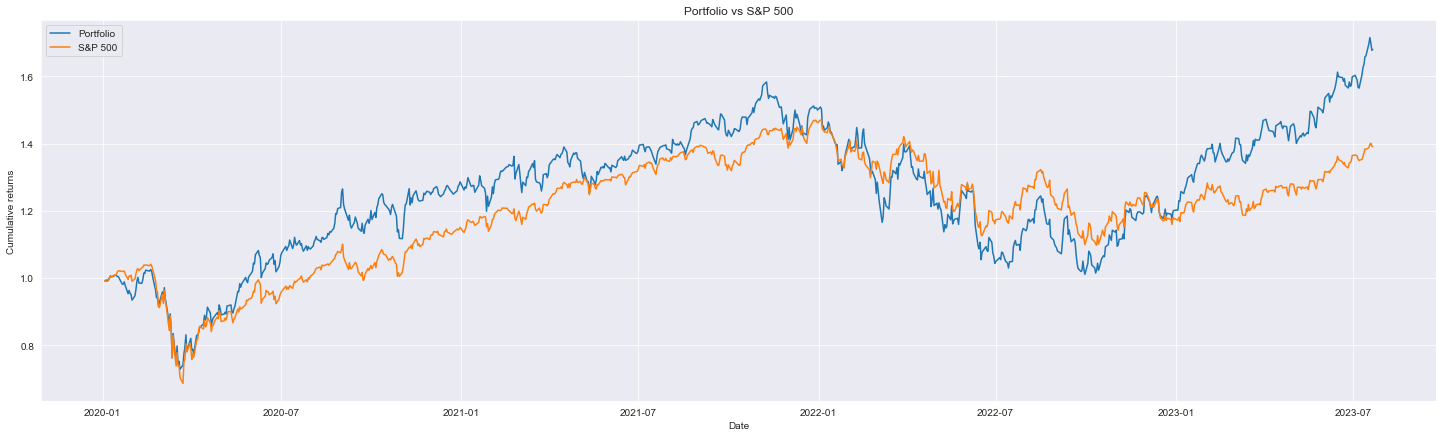

In [16]:
# Download recent data to validate the clustering method
portfolio_data = yf.download(portfolio, start="2020-01-01", end=today)
spy_index_data = yf.download("SPY", start="2020-01-01", end=today)

# Calculate the daily returns for both the stock and the index based on 
# their historical price data
portfolio_daily_returns = portfolio_data["Close"].sum(axis=1).pct_change()
spy_index_daily_returns = spy_index_data["Close"].pct_change()

# Calculate the cumulative returns for both the stock and the index by 
# summing up the daily returns.
portfolio_cumulative_returns = (portfolio_daily_returns + 1).cumprod()
spy_index_cumulative_returns = (spy_index_daily_returns + 1).cumprod()

# plot a comparison
plt.figure(figsize=(25, 7))
plt.plot(portfolio_cumulative_returns, label="Portfolio")
plt.plot(spy_index_cumulative_returns, label="S&P 500")
plt.title("Portfolio vs S&P 500")
plt.xlabel("Date")
plt.ylabel("Cumulative returns")
plt.legend()
plt.show()

We can see that the constructed portfolio outperforms the S&P 500 index. Which means that the used clustering successfully created a diversified portfolio, in terms of the specified features.

### Explainability of the results using SHAP values

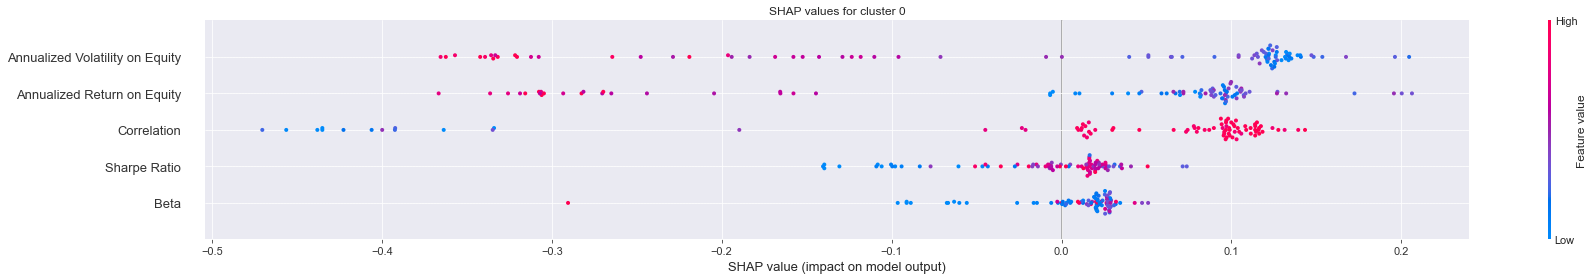

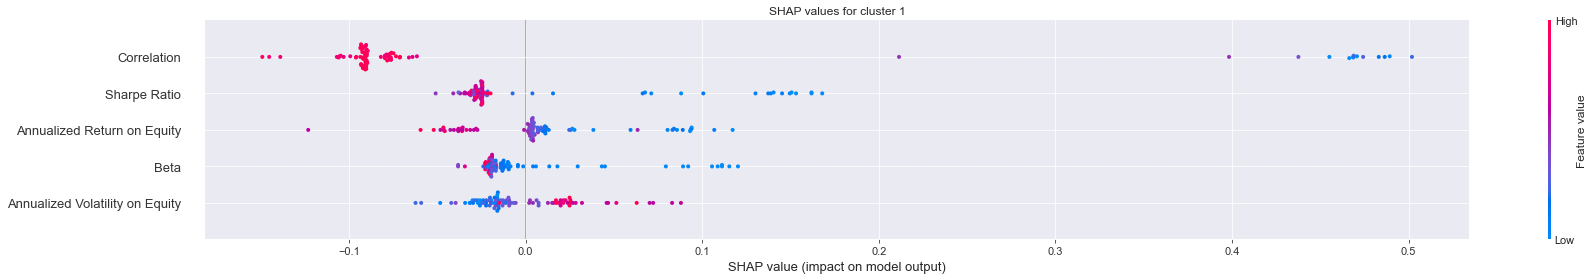

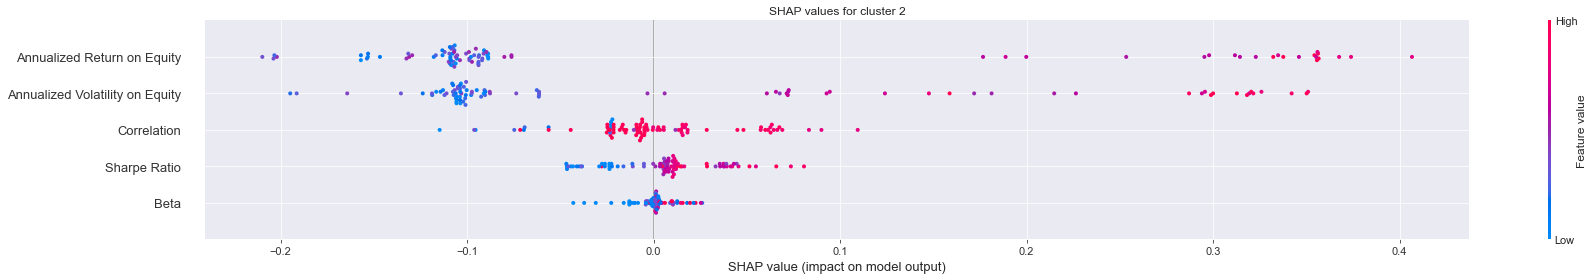

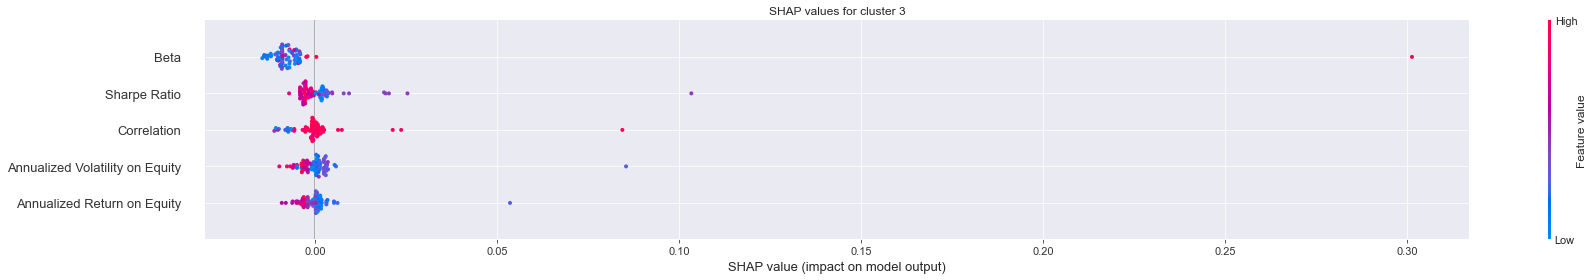

In [17]:
y = kmeans.labels_
clf = RandomForestClassifier()
clf.fit(X, y)

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

for i in range(4) :
    plt.title(f"SHAP values for cluster {i}")
    shap.summary_plot(shap_values[i], X, feature_names=["Annualized Return on Equity",
                                                    "Annualized Volatility on Equity",
                                                    "Sharpe Ratio", "Correlation", "Beta"],
                plot_size=(25, 4))

In each plot, the x-axis gives the SHAP value while the y-axis lists the 5 features ordered by their importance for the specific cluster.

We can see for example that the *Annualized Return on Equity* is the most important feature for cluster 0, but it's the least important for the clusters 1 and 3. 

**It is precisely this difference that we're looking for in our diversified portfolio. In fact, we need to regroup stocks in clusters that don't have the same performance on all the chosen features.**